# 🧬 Protein Classification with PySpark & ML  
**Author:** Pooja Pathare  



Introduction: This dataset contains a wide variety of biologically significant macromolecules. Proteins make up the bulk of the data records. Biomolecules that directly engage in biological pathways and cycles are called proteins; DNA is the precursor to RNA, which is translated into these biomolecules. Based on their family type, proteins are often specialized to one or a few jobs. A protein belonging to the hydrolase group, for instance, is specialized in catalyzing hydrolysis, which is the process of dissolving bonds by adding water, to aid in the breakdown of protein chains or other compounds. An additional illustration would be a transport protein, which permits the entry and exit of other molecules like sucrose, fructose, or even water.

Goal: Given the variety of family types exhibited by these proteins, the question of whether a protein's family type may be inferred from its sequence emerges. It would be interesting to explore if a machine learning technique can effectively categorize a protein's family based on the protein sequence, however there are well-known search engines with this capacity, such as BLAST.

### Importing Libraries

In [40]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StringIndexer, CountVectorizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import SparkConf
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

import pymongo
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, desc, split

import numpy as np

from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import CountVectorizer as CV
from sklearn.feature_extraction.text import CountVectorizer
from pyspark.ml.classification import NaiveBayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from matplotlib.widgets import Slider, Button

%matplotlib inline

### Setup Spark Session

In [41]:
conf = SparkConf().setAppName("BigDataProj").setMaster("local[*]").set("spark.driver.host", "127.0.0.1")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Session Created")

Spark Session Created


In [42]:
try:
    # Connect to MongoDB and retrieve data for classes
    myclient = pymongo.MongoClient("mongodb://localhost:27017/")
    mydb = myclient["bigDataProj"]
    mycol = mydb["pdb_data_no_dups"]
    
    document_count = mycol.count_documents({})
    print("No. of Documents read from the Collection:")
    print(document_count)
    
    # Retrieve data from MongoDB
    mydoc = mycol.find().limit(1)
    
    # Print sample document
    for document in mydoc:
        pprint(document)

except pymongo.errors.ConnectionFailure as e:
    print(f"Error connecting to MongoDB: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

No. of Documents read from the Collection:
141401
{'_id': ObjectId('6568678b5f40a87278b54802'),
 'classification': 'DNA-RNA HYBRID',
 'crystallizationMethod': 'VAPOR DIFFUSION, HANGING DROP',
 'densityMatthews': 1.78,
 'densityPercentSol': 30.89,
 'experimentalTechnique': 'X-RAY DIFFRACTION',
 'macromoleculeType': 'DNA/RNA Hybrid',
 'pdbxDetails': 'pH 7.00, VAPOR DIFFUSION, HANGING DROP',
 'phValue': 7.0,
 'publicationYear': 1994,
 'residueCount': 20,
 'resolution': 1.9,
 'structureId': '100D',
 'structureMolecularWeight': 6360.3}


In [43]:
# Reading csv file from HDFS

hdfs_path_seq = "hdfs://localhost:9000/user/bigData/pdb_data_seq.csv"
df_seq = spark.read.csv(hdfs_path_seq, header=True, inferSchema=True)

print('Datasets from HDFS have been loaded...')

Datasets from HDFS have been loaded...


In [44]:
# Print Schema of Sequence File
df_seq.printSchema()

root
 |-- structureId: string (nullable = true)
 |-- chainId: string (nullable = true)
 |-- sequence: string (nullable = true)
 |-- residueCount: integer (nullable = true)
 |-- macromoleculeType: string (nullable = true)



In [45]:
# Convert document
class_doc = mycol.find()
df_class = pd.DataFrame(list(class_doc))

In [46]:
# Print Schema of Classification File
print(df_class.dtypes)

_id                          object
structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
crystallizationTempK        float64
dtype: object


classification
HYDROLASE                           20915
TRANSFERASE                         15777
OXIDOREDUCTASE                      12494
LYASE                                4329
IMMUNE SYSTEM                        4075
                                    ...  
hormone, Transport protein              1
ANTITUMOR PROTEIN/LIGASE                1
CASPASE RECRUITMENT DOMAIN              1
HYDROLASE, Metal binding protein        1
antimicrobial                           1
Name: count, Length: 5050, dtype: int64


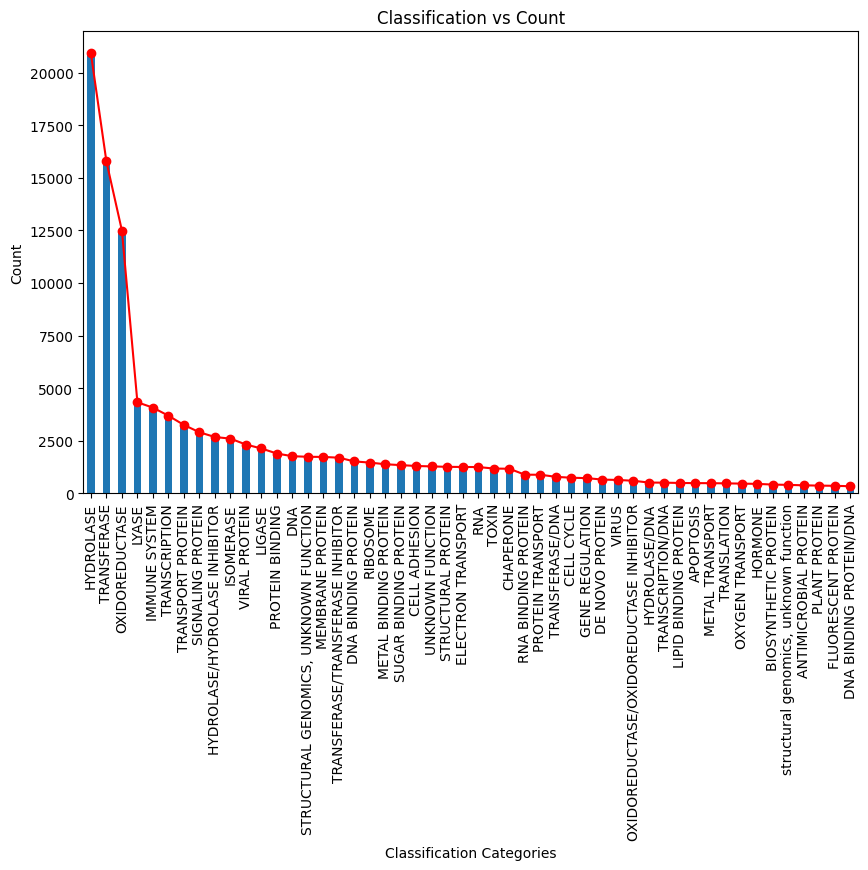

In [47]:
# Perform aggregation on classification
aggregation_result = df_class['classification'].value_counts()
print(aggregation_result)
top_20_labels = aggregation_result.head(50)

 # Visualize the aggregated data
plt.figure(figsize=(10, 6))
top_20_labels.plot(kind='bar')
plt.title('Classification vs Count')
plt.xlabel('Classification Categories')
plt.ylabel('Count')
plt.plot(top_20_labels.index, top_20_labels.values, marker='o', linestyle='-', color='red', label='Line Graph')
plt.show()

In [48]:
# Convert PySpark DataFrames to Pandas DataFrames
df_seq_pd = df_seq.toPandas()

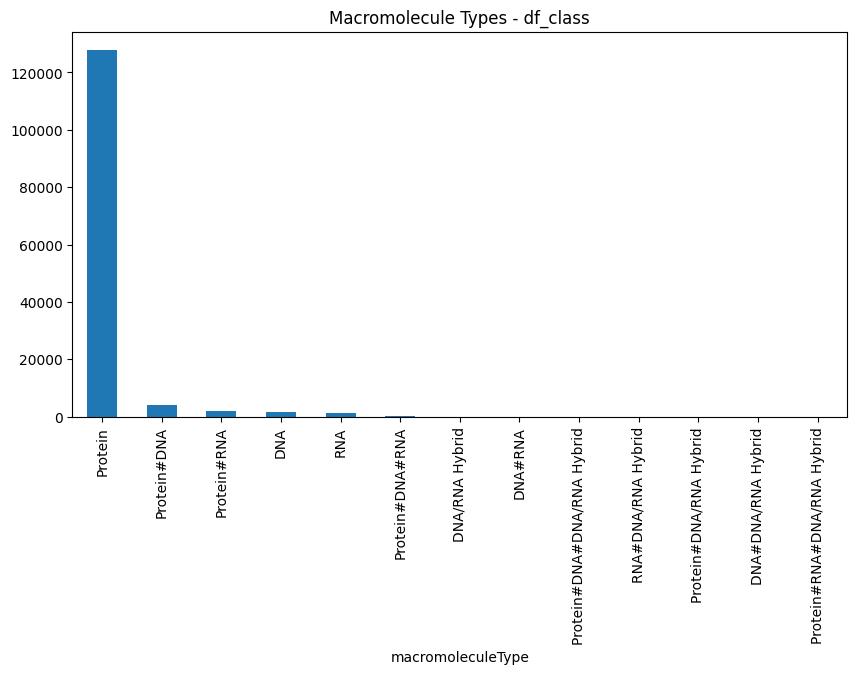

In [49]:
#Plotting MacromoleculeTypes
plt.figure(figsize=(10, 5))
df_class['macromoleculeType'].value_counts().plot(kind='bar', title='Macromolecule Types - df_class')
plt.show()

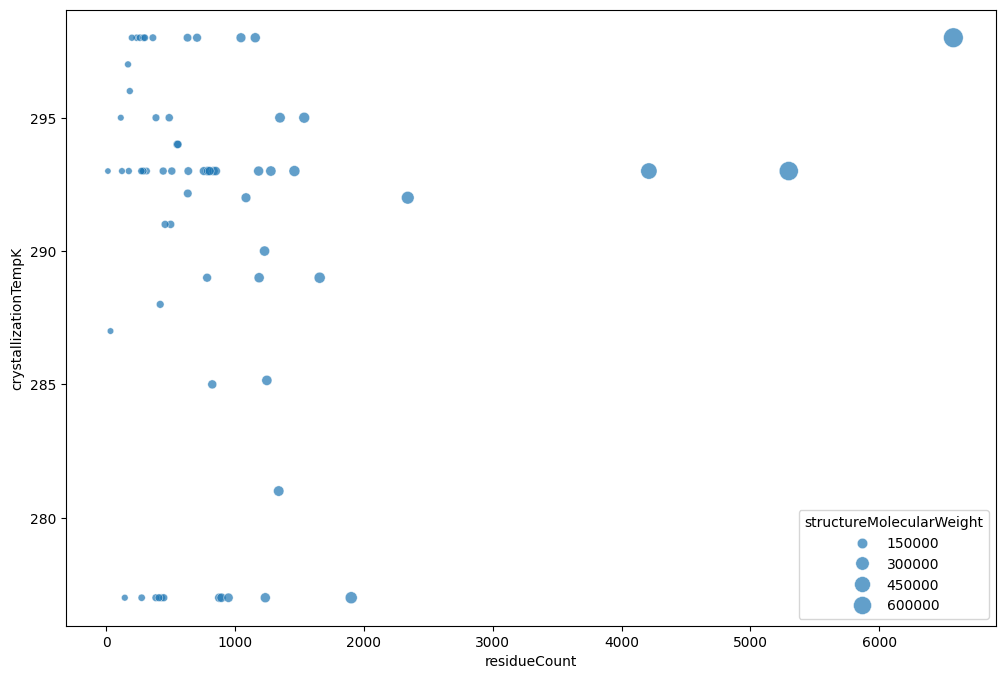

In [50]:
# Sample 1000 rows from the DataFrame
df_sampled = df_class.sample(n=100, random_state=42)

# Create a bubble chart using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='residueCount',
    y='crystallizationTempK',
    size='structureMolecularWeight',
    data=df_sampled,
    sizes=(20, 200),
    alpha=0.7,
    legend='brief'
)

plt.show()

# -------------

In [51]:
# Create a Spark session
spark = SparkSession.builder.appName("ReadFromHDFS").getOrCreate()

23/11/30 17:14:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [53]:
data = spark.read.format("csv").option("header", "true").load('hdfs://localhost:9000/user/bigData/test.csv')

In [54]:
# Step 1: StringIndexer to convert labels to numeric
label_indexer = StringIndexer(inputCol="classification", outputCol="label")


In [55]:
# Step 2: RegexTokenizer to tokenize the 'sequence' column
tokenizer = RegexTokenizer(inputCol="sequence", outputCol="sequence_tokens", pattern="\\W")


In [57]:
# Step 3: CountVectorizer to convert the tokenized 'sequence' column to features
vectorizer = CV(inputCol="sequence_tokens", outputCol="features", vocabSize=1000, minDF=5)


In [58]:
# Step 4: Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction", smoothing=1.0, modelType="multinomial")


In [59]:
# Step 5: Create a pipeline
pipeline = Pipeline(stages=[label_indexer, tokenizer, vectorizer, nb])


In [60]:
# Step 6: Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [61]:
# Step 7: Train the pipeline on the training data
model = pipeline.fit(train_data)


In [62]:
# Step 8: Make predictions on the test data
predictions = model.transform(test_data)


In [63]:
# Step 9: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)


23/11/30 17:22:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [64]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.31376788094980723


# ---------------

Starting a Spark Session

In [65]:
spark = SparkSession.builder.getOrCreate()

Reading both datasets and creating two PySpark Dataframes

In [66]:
df_seq = spark.read.format("csv").option("header","true").load('hdfs://localhost:9000/user/bigData/pdb_data_seq.csv')
df_class = spark.read.format("csv").option("header","true").load('hdfs://localhost:9000/user/bigData/pdb_data_no_dups.csv')
print("Dataset read from HDFS")

Dataset read from HDFS


### Performing Exploratory Data Analysis (EDA) with PySpark components

Analyzing the Schema of the datasets

In [67]:
df_seq.printSchema()

root
 |-- structureId: string (nullable = true)
 |-- chainId: string (nullable = true)
 |-- sequence: string (nullable = true)
 |-- residueCount: string (nullable = true)
 |-- macromoleculeType: string (nullable = true)



In [68]:
df_class.printSchema()

root
 |-- structureId: string (nullable = true)
 |-- classification: string (nullable = true)
 |-- experimentalTechnique: string (nullable = true)
 |-- macromoleculeType: string (nullable = true)
 |-- residueCount: string (nullable = true)
 |-- resolution: string (nullable = true)
 |-- structureMolecularWeight: string (nullable = true)
 |-- crystallizationMethod: string (nullable = true)
 |-- crystallizationTempK: string (nullable = true)
 |-- densityMatthews: string (nullable = true)
 |-- densityPercentSol: string (nullable = true)
 |-- pdbxDetails: string (nullable = true)
 |-- phValue: string (nullable = true)
 |-- publicationYear: string (nullable = true)



Filtering the datasets for 'Protein' as the macromolecule type

In [69]:
protein_seq = df_seq.filter(col("macromoleculeType") == "Protein")
protein_class = df_class.filter(col("macromoleculeType") == "Protein")
protein_seq.show()

+-----------+-------+--------------------+------------+-----------------+
|structureId|chainId|            sequence|residueCount|macromoleculeType|
+-----------+-------+--------------------+------------+-----------------+
|       101M|      A|MVLSEGEWQLVLHVWAK...|         154|          Protein|
|       102L|      A|MNIFEMLRIDEGLRLKI...|         165|          Protein|
|       102M|      A|MVLSEGEWQLVLHVWAK...|         154|          Protein|
|       103L|      A|MNIFEMLRIDEGLRLKI...|         167|          Protein|
|       103M|      A|MVLSEGEWQLVLHVWAK...|         154|          Protein|
|       104L|      A|MNIFEMLRIDEGLRLKI...|         332|          Protein|
|       104L|      B|MNIFEMLRIDEGLRLKI...|         332|          Protein|
|       104M|      A|VLSEGEWQLVLHVWAKV...|         153|          Protein|
|       105M|      A|VLSEGEWQLVLHVWAKV...|         153|          Protein|
|       106M|      A|MVLSEGEWQLVLHVWAK...|         154|          Protein|
|       107L|      A|MNIFEMLRIDEGLRLKI

Creating two new PySpark dataframes by selecting only 'sequence' and 'classification' columns

In [70]:
protein_seq = protein_seq.select('structureId','sequence')
protein_class = protein_class.select('structureId','classification')

In [71]:
protein_seq.show()

+-----------+--------------------+
|structureId|            sequence|
+-----------+--------------------+
|       101M|MVLSEGEWQLVLHVWAK...|
|       102L|MNIFEMLRIDEGLRLKI...|
|       102M|MVLSEGEWQLVLHVWAK...|
|       103L|MNIFEMLRIDEGLRLKI...|
|       103M|MVLSEGEWQLVLHVWAK...|
|       104L|MNIFEMLRIDEGLRLKI...|
|       104L|MNIFEMLRIDEGLRLKI...|
|       104M|VLSEGEWQLVLHVWAKV...|
|       105M|VLSEGEWQLVLHVWAKV...|
|       106M|MVLSEGEWQLVLHVWAK...|
|       107L|MNIFEMLRIDEGLRLKI...|
|       107M|MVLSEGEWQLVLHVWAK...|
|       108L|MNIFEMLRIDEGLRLKI...|
|       108M|MVLSEGEWQLVLHVWAK...|
|       109L|MNIFEMLRIDEGLRLKI...|
|       109M|MVLSEGEWQLVLHVWAK...|
|       10GS|PPYTVVYFPVRGRCAAL...|
|       10GS|PPYTVVYFPVRGRCAAL...|
|       110L|MNIFEMLRIDEGLRLKI...|
|       110M|MVLSEGEWQLVLHVWAK...|
+-----------+--------------------+
only showing top 20 rows



In [72]:
protein_class.show()

+-----------+--------------------+
|structureId|      classification|
+-----------+--------------------+
|       101M|    OXYGEN TRANSPORT|
|       102L|HYDROLASE(O-GLYCO...|
|       102M|    OXYGEN TRANSPORT|
|       103L|HYDROLASE(O-GLYCO...|
|       103M|    OXYGEN TRANSPORT|
|       104L|HYDROLASE(O-GLYCO...|
|       104M|    OXYGEN TRANSPORT|
|       105M|    OXYGEN TRANSPORT|
|       106M|    OXYGEN TRANSPORT|
|       107L|HYDROLASE(O-GLYCO...|
|       107M|    OXYGEN TRANSPORT|
|       108L|HYDROLASE(O-GLYCO...|
|       108M|    OXYGEN TRANSPORT|
|       109L|HYDROLASE(O-GLYCO...|
|       109M|    OXYGEN TRANSPORT|
|       10GS|TRANSFERASE/TRANS...|
|       110L|HYDROLASE(O-GLYCO...|
|       110M|    OXYGEN TRANSPORT|
|       111L|HYDROLASE(O-GLYCO...|
|       111M|    OXYGEN TRANSPORT|
+-----------+--------------------+
only showing top 20 rows



Joining the two dataframes and creating a new combined dataframe with a common 'structureId'

In [73]:
preprocessed_dataset = protein_class.join(protein_seq, on='structureId')
preprocessed_dataset.show()

+-----------+--------------------+--------------------+
|structureId|      classification|            sequence|
+-----------+--------------------+--------------------+
|       101M|    OXYGEN TRANSPORT|MVLSEGEWQLVLHVWAK...|
|       102L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLRLKI...|
|       102M|    OXYGEN TRANSPORT|MVLSEGEWQLVLHVWAK...|
|       103L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLRLKI...|
|       103M|    OXYGEN TRANSPORT|MVLSEGEWQLVLHVWAK...|
|       104L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLRLKI...|
|       104L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLRLKI...|
|       104M|    OXYGEN TRANSPORT|VLSEGEWQLVLHVWAKV...|
|       105M|    OXYGEN TRANSPORT|VLSEGEWQLVLHVWAKV...|
|       106M|    OXYGEN TRANSPORT|MVLSEGEWQLVLHVWAK...|
|       107L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLRLKI...|
|       107M|    OXYGEN TRANSPORT|MVLSEGEWQLVLHVWAK...|
|       108L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLRLKI...|
|       108M|    OXYGEN TRANSPORT|MVLSEGEWQLVLHVWAK...|
|       109L|HYDROLASE(O-GLYCO...|MNIFEMLRIDEGLR

Checking the schema of the new dataframe and its column datatypes

In [74]:
preprocessed_dataset.printSchema()

root
 |-- structureId: string (nullable = true)
 |-- classification: string (nullable = true)
 |-- sequence: string (nullable = true)



In [75]:
pd.DataFrame(preprocessed_dataset.dtypes, columns = ['Column Name', 'Data Type'])

,Column Name,Data Type
0,structureId,string
1,classification,string
2,sequence,string


Calculating the shape of the dataframe

In [76]:
num_rows = preprocessed_dataset.count()
num_cols = len(preprocessed_dataset.columns)
print("Shape of the dataset: ({},{})".format(num_rows,num_cols))

Shape of the dataset: (346325,3)


Checking for any Null values in the dataset

In [77]:
null_count = preprocessed_dataset.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in preprocessed_dataset.columns])
null_count.show()

+-----------+--------------+--------+
|structureId|classification|sequence|
+-----------+--------------+--------+
|          0|             1|       3|
+-----------+--------------+--------+



Dropping the null values and updating the dataset

In [78]:
preprocessed_dataset = preprocessed_dataset.dropna()

Checking for null values again just to confirm all null values have been dropped

In [79]:
null_count = preprocessed_dataset.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in preprocessed_dataset.columns])
null_count.show()
print("Null values removed\n")

num_rows_1 = preprocessed_dataset.count()
num_cols_1 = len(preprocessed_dataset.columns)
print("Shape of the dataset: ({},{})".format(num_rows_1,num_cols_1))

+-----------+--------------+--------+
|structureId|classification|sequence|
+-----------+--------------+--------+
|          0|             0|       0|
+-----------+--------------+--------+

Null values removed

Shape of the dataset: (346321,3)


Checking for duplicate rows in the dataset

In [80]:
row_counts = preprocessed_dataset.groupBy(preprocessed_dataset.columns).count()
duplicates_df = row_counts.filter(col("count") > 1)
duplicates_df.show()

print("Number of rows having duplicates: {}".format(duplicates_df.count()))

total_duplicate_count = duplicates_df.agg(sum("count")).collect()[0][0]
print("\nTotal number of duplicates: {}".format(total_duplicate_count-duplicates_df.count()))

+-----------+--------------------+--------------------+-----+
|structureId|      classification|            sequence|count|
+-----------+--------------------+--------------------+-----+
|       1A4J|      IMMUNOGLOBULIN|QVQLLESGPELKKPGET...|    2|
|       1AYO|       MACROGLOBULIN|EFPFALEVQTLPQTCDG...|    2|
|       1BAV|    CARBOXYPEPTIDASE|ARSTNTFNYATYHTLDE...|    4|
|       1BOS|               TOXIN|TPDCVTGKVEYTKYNDD...|   20|
|       1BRJ|        ENDONUCLEASE|AQVINTFDGVADYLQTY...|    3|
|       1C3X|         TRANSFERASE|PPLDDPATDPFLVARAA...|    3|
|       1C41|         TRANSFERASE|MHTKGPTPQQHDGSALR...|   10|
|       1CM5|         TRANSFERASE|SELNEKLATAWEGFTKG...|    2|
|       1CMV|     SERINE PROTEASE|MTMDEQQSQAVAPVYVG...|    2|
|       1CN3|       VIRAL PROTEIN|MEVLDLVTGPDSVTEIE...|    5|
|       1CR6|           HYDROLASE|MALRVAAFDLDGVLALP...|    2|
|       1D9C|       IMMUNE SYSTEM|QGQFFREIENLKEYFNA...|    2|
|       1DAZ|HYDROLASE/HYDROLA...|PQITLWKRPLVTIKIGG...|    2|
|       

Number of rows having duplicates: 81540



Total number of duplicates: 179644


Dropping duplicates and creating a new updated dataframe

In [81]:
processed_dataset = preprocessed_dataset.dropDuplicates()

Checking for duplicates again and checking the shape of the dataframe after removal of duplicates

In [82]:
row_counts = processed_dataset.groupBy(processed_dataset.columns).count()
duplicates_df = row_counts.filter(col("count") > 1)
print("Total number of duplicates: {}".format(duplicates_df.count()))

num_rows_2 = processed_dataset.count()
num_cols_2 = len(processed_dataset.columns)
print("\nRemaining rows after duplicates removal: {} - {} = {}".format(num_rows_1,num_rows_1-num_rows_2,num_rows_2))
print("\nShape of the dataset after removal of duplicates: ({},{})".format(num_rows_2,num_cols_2))

Total number of duplicates: 0

Remaining rows after duplicates removal: 346321 - 179644 = 166677

Shape of the dataset after removal of duplicates: (166677,3)


### Visualizing the Dataset

The dataset is quite large and visualization of such a large dataset can be difficult to understand. Therefore, as this is a classification prediction, we have created a new dataframe for visualization by grouping the data by 'classification' and ordering it in descending order by its count.

In [83]:
class_count = processed_dataset.groupBy("classification").count().orderBy(desc("count"))
class_count.show()
#print(type(class_count))
print("Number of unique classes: {}".format(class_count.count()))
class_count_pd = class_count.limit(50).toPandas()

+--------------------+-----+
|      classification|count|
+--------------------+-----+
|           HYDROLASE|24196|
|         TRANSFERASE|17025|
|      OXIDOREDUCTASE|14742|
|       IMMUNE SYSTEM| 9002|
|HYDROLASE/HYDROLA...| 6389|
|       TRANSCRIPTION| 4859|
|               LYASE| 4566|
|   TRANSPORT PROTEIN| 3852|
|   SIGNALING PROTEIN| 3553|
|       VIRAL PROTEIN| 2923|
|           ISOMERASE| 2578|
|     PROTEIN BINDING| 2485|
|              LIGASE| 2437|
|    MEMBRANE PROTEIN| 2290|
|TRANSFERASE/TRANS...| 1916|
|  STRUCTURAL PROTEIN| 1722|
|  ELECTRON TRANSPORT| 1698|
|STRUCTURAL GENOMI...| 1650|
| DNA BINDING PROTEIN| 1570|
|       CELL ADHESION| 1540|
+--------------------+-----+
only showing top 20 rows



Number of unique classes: 4468


The number of unique protein classes is a large number which is not feasible to visualize because it would limit the understanding. Therefore, we are visualizing this dataframe with a Bar plot for the top 50 Protein Classification. 

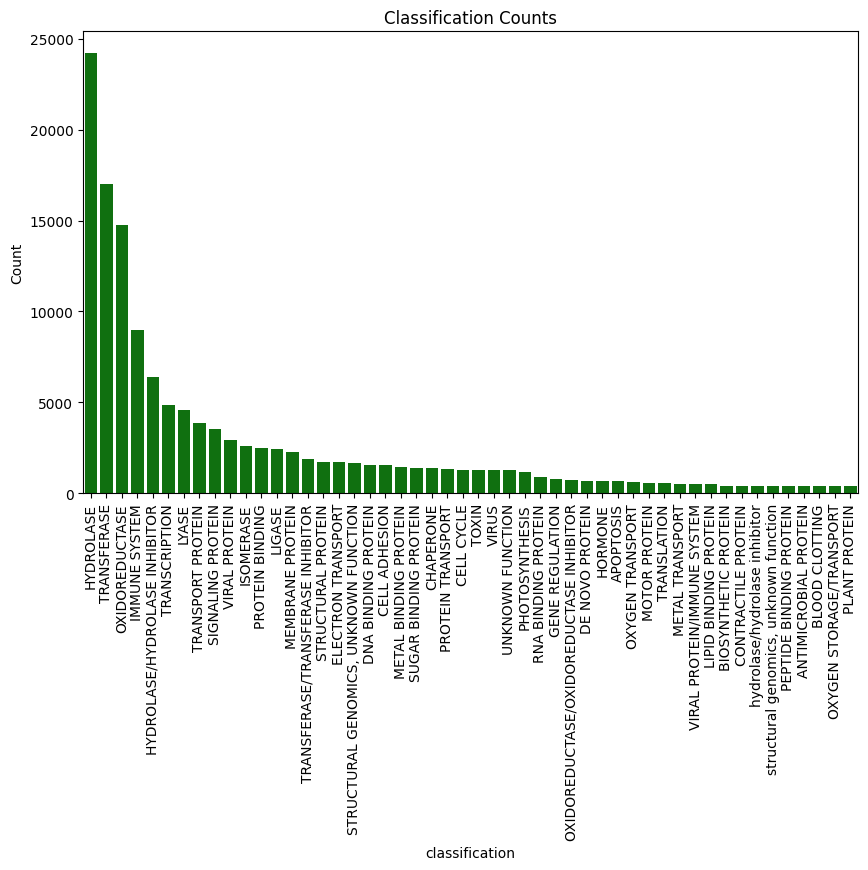

In [84]:
plt.figure(figsize=(10,6))
sns.barplot(x='classification',y='count', data=class_count_pd , color = 'green')
plt.title('Classification Counts')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

After visualizing this barplot, we came to know that only a few of the classes have a very high count in the dataset. So, it makes sense to choose the classes which have a count greater than 1000. Classes with count below 1000 would not provide much significance to the machine learning prediction.

Filtering the dataset based on class count being greater than 999 and preparing the final processed dataset for ML training

In [85]:
chosen_types = class_count.filter(col("count") >= 1000)
classes = chosen_types.select('classification').rdd.flatMap(lambda x: x).collect()
final_dataset = processed_dataset.filter(col("classification").isin(classes))
final_dataset.show()
num_rows_3 = final_dataset.count()
num_cols_3 = len(final_dataset.columns)
print("\nShape of the final dataset: ({},{})".format(num_rows_3,num_cols_3))

+-----------+--------------------+--------------------+
|structureId|      classification|            sequence|
+-----------+--------------------+--------------------+
|       1A5J| DNA BINDING PROTEIN|GIPDLVKGPWTKEEDQK...|
|       1A65|      OXIDOREDUCTASE|QIVNSVDTMTLTNANVS...|
|       1B3J|       IMMUNE SYSTEM|EPHSLRYNLTVLSWDGS...|
|       1B5G|HYDROLASE/HYDROLA...|IVEGSDAEIGMSPWQVM...|
|       1BOS|               TOXIN|TPDCVTGKVEYTKYNDD...|
|       1C3X|         TRANSFERASE|PPLDDPATDPFLVARAA...|
|       1C41|         TRANSFERASE|MHTKGPTPQQHDGSALR...|
|       1CM5|         TRANSFERASE|SELNEKLATAWEGFTKG...|
|       1CN3|       VIRAL PROTEIN|MEVLDLVTGPDSVTEIE...|
|       1CR6|           HYDROLASE|MALRVAAFDLDGVLALP...|
|       1D4D|      OXIDOREDUCTASE|AAPEVLADFHGEMGGCD...|
|       1D5G|           HYDROLASE|     FADSEADENEQVSAV|
|       1D9C|       IMMUNE SYSTEM|QGQFFREIENLKEYFNA...|
|       1DAN|HYDROLASE/HYDROLA...|ANAFLEELRPGSLEREC...|
|       1DAX|  ELECTRON TRANSPORT|ARKFYVDQDECIAC

### Feature Extraction & Dataset Split

Splitting the dataset for training and testing with 80% and 20% respectively. CountVectorizer is a feature extraction technique in natural language processing (NLP) that is commonly used to convert a collection of text documents to a matrix of token counts. CountVectorizer here is to create a sparse matrix from the training dataset. This will extract individual subsets of characters based on the ngram_range in order to gain more features.

In [86]:
final_dataset_pd = final_dataset.toPandas()
X_train, X_test,y_train,y_test = train_test_split(final_dataset_pd['sequence'], final_dataset_pd['classification'], test_size = 0.2, random_state = 1)
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)
print(vect.get_feature_names_out()[-10:])

['zpvm' 'zrgd' 'zrvi' 'ztvl' 'ztzk' 'zvbd' 'zvib' 'zvka' 'zwdl' 'zzvb']


### Training & Testing

We are using Multinomial Naive Bayes algorithm as this approach works well with count vectorized features.

In [87]:
start_time = time.time()
mnb = MultinomialNB()
mnb.fit(X_train_df,y_train)
y_pred = mnb.predict(X_test_df)
end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
print("\nPrecision: {:.2%}".format(precision))

recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
print("\nRecall: {:.2%}".format(recall))

f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print("\nF1 Score: {:.2%}".format(f1))

Time taken: 1.40 seconds

Accuracy: 68.52%

Precision: 72.28%

Recall: 68.52%

F1 Score: 69.79%


## ✅ Summary
This notebook demonstrates how exploratory data analysis and multiple machine learning classifiers can be applied to classify protein sequences using PySpark and Scikit-learn.  
It highlights practical data science techniques in the bioinformatics domain.
